#**Objectives of this module**


1.   Demonstrate Object Detection on trained model
2.   Demonstrate Working of Kalman filter for tracking
3.   Demonstrate combined detection and tracking algorithms on video file input



# Importing test video and Model 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 
!cp "/content/gdrive/MyDrive/driving_label_map.pbtxt" "/content"
!cp "/content/gdrive/MyDrive/sample_vid2.mp4" "/content"
!cp "/content/gdrive/MyDrive/saved_model.zip" "/content"

# Upload Helpers.py

Mounted at /content/gdrive


# Defining bounding box functions 

In [17]:
import collections
import os
import numpy as np
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import six
import tensorflow as tf
import cv2
from numpy import dot
from scipy.linalg import inv, block_diag
import matplotlib.pyplot as plt
import glob
import Helpers
import matplotlib.pyplot as plt
import time
from moviepy.editor import VideoFileClip
from collections import deque



_TITLE_LEFT_MARGIN = 10
_TITLE_TOP_MARGIN = 10
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]


def save_image_array_as_png(image, output_path):
  """Saves an image (represented as a numpy array) to PNG.
  Args:
    image: a numpy array with shape [height, width, 3].
    output_path: path to which image should be written.
  """
  image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
  with tf.gfile.Open(output_path, 'w') as fid:
    image_pil.save(fid, 'PNG')


def encode_image_array_as_png_str(image):
  """Encodes a numpy array into a PNG string.
  Args:
    image: a numpy array with shape [height, width, 3].
  Returns:
    PNG encoded image string.
  """
  image_pil = Image.fromarray(np.uint8(image))
  output = six.StringIO()
  image_pil.save(output, format='PNG')
  png_string = output.getvalue()
  output.close()
  return png_string


def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color='red',
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
  """Adds a bounding box to an image (numpy array).
  Args:
    image: a numpy array with shape [height, width, 3].
    ymin: ymin of bounding box in normalized coordinates (same below).
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
  draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                             thickness, display_str_list,
                             use_normalized_coordinates)
  np.copyto(image, np.array(image_pil))


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.
  Each string in display_str_list is displayed on a separate line above the
  bounding box in black text on a rectangle filled with the input 'color'.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  try:
    font = ImageFont.truetype('arial.ttf', 24)
  except IOError:
    font = ImageFont.load_default()

  text_bottom = top
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
        fill=color)
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
    text_bottom -= text_height - 2 * margin


def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color='red',
                                       thickness=4,
                                       display_str_list_list=()):
  """Draws bounding boxes on image (numpy array).
  Args:
    image: a numpy array object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: list of list of strings.
                           a list of strings for each bounding box.
                           The reason to pass a list of strings for a
                           bounding box is that it might contain
                           multiple labels.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  image_pil = Image.fromarray(image)
  draw_bounding_boxes_on_image(image_pil, boxes, color, thickness,
                               display_str_list_list)
  np.copyto(image, np.array(image_pil))


def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color='red',
                                 thickness=4,
                                 display_str_list_list=()):
  """Draws bounding boxes on image.
  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: list of list of strings.
                           a list of strings for each bounding box.
                           The reason to pass a list of strings for a
                           bounding box is that it might contain
                           multiple labels.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    display_str_list = ()
    if display_str_list_list:
      display_str_list = display_str_list_list[i]
    draw_bounding_box_on_image(image, boxes[i, 0], boxes[i, 1], boxes[i, 2],
                               boxes[i, 3], color, thickness, display_str_list)


def draw_keypoints_on_image_array(image,
                                  keypoints,
                                  color='red',
                                  radius=2,
                                  use_normalized_coordinates=True):
  """Draws keypoints on an image (numpy array).
  Args:
    image: a numpy array with shape [height, width, 3].
    keypoints: a numpy array with shape [num_keypoints, 2].
    color: color to draw the keypoints with. Default is red.
    radius: keypoint radius. Default value is 2.
    use_normalized_coordinates: if True (default), treat keypoint values as
      relative to the image.  Otherwise treat them as absolute.
  """
  image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
  draw_keypoints_on_image(image_pil, keypoints, color, radius,
                          use_normalized_coordinates)
  np.copyto(image, np.array(image_pil))


def draw_keypoints_on_image(image,
                            keypoints,
                            color='red',
                            radius=2,
                            use_normalized_coordinates=True):
  """Draws keypoints on an image.
  Args:
    image: a PIL.Image object.
    keypoints: a numpy array with shape [num_keypoints, 2].
    color: color to draw the keypoints with. Default is red.
    radius: keypoint radius. Default value is 2.
    use_normalized_coordinates: if True (default), treat keypoint values as
      relative to the image.  Otherwise treat them as absolute.
  """
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  keypoints_x = [k[1] for k in keypoints]
  keypoints_y = [k[0] for k in keypoints]
  if use_normalized_coordinates:
    keypoints_x = tuple([im_width * x for x in keypoints_x])
    keypoints_y = tuple([im_height * y for y in keypoints_y])
  for keypoint_x, keypoint_y in zip(keypoints_x, keypoints_y):
    draw.ellipse([(keypoint_x - radius, keypoint_y - radius),
                  (keypoint_x + radius, keypoint_y + radius)],
                 outline=color, fill=color)


def draw_mask_on_image_array(image, mask, color='red', alpha=0.7):
  """Draws mask on an image.
  Args:
    image: uint8 numpy array with shape (img_height, img_height, 3)
    mask: a float numpy array of shape (img_height, img_height) with
      values between 0 and 1
    color: color to draw the keypoints with. Default is red.
    alpha: transparency value between 0 and 1. (default: 0.7)
  Raises:
    ValueError: On incorrect data type for image or masks.
  """
  if image.dtype != np.uint8:
    raise ValueError('`image` not of type np.uint8')
  if mask.dtype != np.float32:
    raise ValueError('`mask` not of type np.float32')
  if np.any(np.logical_or(mask > 1.0, mask < 0.0)):
    raise ValueError('`mask` elements should be in [0, 1]')
  rgb = ImageColor.getrgb(color)
  pil_image = Image.fromarray(image)

  solid_color = np.expand_dims(
      np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
  pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert('RGBA')
  pil_mask = Image.fromarray(np.uint8(255.0*alpha*mask)).convert('L')
  pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
  np.copyto(image, np.array(pil_image.convert('RGB')))


def visualize_boxes_and_labels_on_image_array(image,
                                              boxes,
                                              classes,
                                              scores,
                                              category_index,
                                              instance_masks=None,
                                              keypoints=None,
                                              use_normalized_coordinates=False,
                                              max_boxes_to_draw=20,
                                              min_score_thresh=.5,
                                              agnostic_mode=False,
                                              line_thickness=4):
  """Overlay labeled boxes on an image with formatted scores and label names.
  This function groups boxes that correspond to the same location
  and creates a display string for each detection and overlays these
  on the image.  Note that this function modifies the image array in-place
  and does not return anything.
  Args:
    image: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    instance_masks: a numpy array of shape [N, image_height, image_width], can
      be None
    keypoints: a numpy array of shape [N, num_keypoints, 2], can
      be None
    use_normalized_coordinates: whether boxes is to be interpreted as
      normalized coordinates or not.
    max_boxes_to_draw: maximum number of boxes to visualize.  If None, draw
      all boxes.
    min_score_thresh: minimum score threshold for a box to be visualized
    agnostic_mode: boolean (default: False) controlling whether to evaluate in
      class-agnostic mode or not.  This mode will display scores but ignore
      classes.
    line_thickness: integer (default: 4) controlling line width of the boxes.
  """
  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_masks_map = {}
  box_to_keypoints_map = collections.defaultdict(list)
  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
      if instance_masks is not None:
        box_to_instance_masks_map[box] = instance_masks[i]
      if keypoints is not None:
        box_to_keypoints_map[box].extend(keypoints[i])
      if scores is None:
        box_to_color_map[box] = 'black'
      else:
        if not agnostic_mode:
          if classes[i] in category_index.keys():
            class_name = category_index[classes[i]]
          else:
            class_name = 'N/A'
          display_str = '{}: {}%'.format(
              class_name,
              int(100*scores[i]))
        else:
          display_str = 'score: {}%'.format(int(100 * scores[i]))
        box_to_display_str_map[box].append(display_str)
        if agnostic_mode:
          box_to_color_map[box] = 'DarkOrange'
        else:
          box_to_color_map[box] = STANDARD_COLORS[
              classes[i] % len(STANDARD_COLORS)]

  # Draw all boxes onto image.
  for box, color in six.iteritems(box_to_color_map):
    ymin, xmin, ymax, xmax = box
    if instance_masks is not None:
      draw_mask_on_image_array(
          image,
          box_to_instance_masks_map[box],
          color=color
      )
    draw_bounding_box_on_image_array(
        image,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=line_thickness,
        display_str_list=box_to_display_str_map[box],
        use_normalized_coordinates=use_normalized_coordinates)
    if keypoints is not None:
      draw_keypoints_on_image_array(
          image,
          box_to_keypoints_map[box],
          color=color,
          radius=line_thickness / 2,
          use_normalized_coordinates=use_normalized_coordinates)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2744320/45929032 bytes (6.0%)6078464/45929032 bytes (13.2%)9478144/45929032 bytes (20.6%)12902400/45929032 bytes (28.1%)16056320/45929032 bytes (35.0%)19488768/45929032 bytes (42.4%)22732800/45929032 bytes (49.5%)25780224/45929032 bytes (56.1%)29294592/45929032 bytes (63.8%)32391168/45929032 bytes (70.5%)35659776/45929032 bytes (77.6%)38846464/45929032 bytes (84.6%)

# Reading trained model

In [ ]:
!unzip /content/saved_model.zip 
def read_label_map(file):
   f = open(file)
   data = f.read()
   data = data.strip().rstrip('\n')
   data = data.replace('\n', '')
   data_lst = data.split('item')
   data_lst = [d for d in data_lst if not d=='']
   f.close()
   return dict([(int(b[b.index('id')+3:b.index('name')].strip()),
	b[b.index('name')+5:b.index('}')].strip().replace("'","")) for b in data_lst])

Archive:  /content/saved_model.zip
   creating: saved_model/assets/
  inflating: saved_model/saved_model.pb  
   creating: saved_model/variables/
  inflating: saved_model/variables/variables.data-00000-of-00001  
  inflating: saved_model/variables/variables.index  


# Setting up model for detection

In [ ]:
category_index = read_label_map('driving_label_map.pbtxt')
PATH_TO_SAVED_MODEL = "./saved_model"
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

# Performing object detection on video

In [ ]:
def box_normal_to_pixel(box, dim):
    height, width = dim[0], dim[1]
    box_pixel = [int(box[0]*height), int(box[1]*width), int(box[2]*height), int(box[3]*width)]
    return np.array(box_pixel)


cap = cv2.VideoCapture('sample_vid2.mp4')
writer = cv2.VideoWriter("detection_output_final.mp4", cv2.VideoWriter_fourcc('M','P','4','V'), 10,(628,316))
while cap.isOpened():
  ret, frame = cap.read()
  #print(frame.shape)
  if ret:
    input_tensor = tf.convert_to_tensor(frame)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = frame.copy()

    visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.40,
          agnostic_mode=False)
    writer.write(image_np_with_detections) #write to video output stream          
  else:
    break

writer.release()
cap.release()
boxes = detections['detection_boxes']
classes = detections['detection_classes']
scores = detections['detection_scores']

def get_classes(classes):
  classes =np.squeeze(classes)
  return classes

detection_cache =[] #a list of tuples each tuple is an object with ( box-cordinates, class and score)
for i in range(num_detections):
  box = boxes[i]
  box_class = classes[i]
  score = scores[i]
  detection_cache.append((box,box_class,score))


print("The video was successfully saved")

def get_localization_helper(classes,image_np_with_detections):
    cls = classes.tolist()
    obj_classes = [i for i in range(1,12)]
    idx_vec = [i for i, v in enumerate(cls) if ((v in obj_classes) and (scores[i]>0.3))]
    Objkt_boxes = [] 
    if len(idx_vec) ==0:
        print('no detection!')
        Objkt_boxes = []  
    else:
        tmp_Objkt_boxes=[]
        for idx in idx_vec:
            dim = image_np_with_detections.shape[0:2]
            box = box_normal_to_pixel(boxes[idx], dim)
            box_h = box[2] - box[0]
            box_w = box[3] - box[1]
            ratio = box_h/(box_w + 0.01)
            tmp_Objkt_boxes.append(box)
            print( box, ', confidence: ', scores[idx], 'ratio:', ratio,"class : ",classes[idx])          
        Objkt_boxes = tmp_Objkt_boxes
        return Objkt_boxes

  
def get_localization(img):
  return get_localization_helper(get_classes(classes),img)

def GetDetectedObjects():
  return detection_cache



The video was successfully saved


# Defining Kalman filter for tracking 

In [ ]:
class Tracker(): # class for Kalman Filter-based tracker
    def __init__(self):
        # Initialize parametes for tracker (history)
        self.id = 0  # tracker's id 
        self.box = [] # list to store the coordinates for a bounding box 
        self.hits = 0 # number of detection matches
        self.no_losses = 0 # number of unmatched tracks (track loss)
        
        # Initialize parameters for Kalman Filtering
        # The state is the (x, y) coordinates of the detection box
        # state: [up, up_dot, left, left_dot, down, down_dot, right, right_dot]
        # or[up, up_dot, left, left_dot, height, height_dot, width, width_dot]
        self.x_state=[] 
        self.dt = 1.   # time interval
        
        # Process matrix, assuming constant velocity model
        self.F = np.array([[1, self.dt, 0,  0,  0,  0,  0, 0],
                           [0, 1,  0,  0,  0,  0,  0, 0],
                           [0, 0,  1,  self.dt, 0,  0,  0, 0],
                           [0, 0,  0,  1,  0,  0,  0, 0],
                           [0, 0,  0,  0,  1,  self.dt, 0, 0],
                           [0, 0,  0,  0,  0,  1,  0, 0],
                           [0, 0,  0,  0,  0,  0,  1, self.dt],
                           [0, 0,  0,  0,  0,  0,  0,  1]])
        
        # Measurement matrix, assuming we can only measure the coordinates
        
        self.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 1, 0, 0, 0], 
                           [0, 0, 0, 0, 0, 0, 1, 0]])
        
        
        # Initialize the state covariance
        self.L = 10.0
        self.P = np.diag(self.L*np.ones(8))
        
        
        # Initialize the process covariance
        self.Q_comp_mat = np.array([[self.dt**4/4., self.dt**3/2.],
                                    [self.dt**3/2., self.dt**2]])
        self.Q = block_diag(self.Q_comp_mat, self.Q_comp_mat, 
                            self.Q_comp_mat, self.Q_comp_mat)
        
        # Initialize the measurement covariance
        self.R_scaler = 1.0
        self.R_diag_array = self.R_scaler * np.array([self.L, self.L, self.L, self.L])
        self.R = np.diag(self.R_diag_array)
        
        
    def update_R(self):   
        R_diag_array = self.R_scaler * np.array([self.L, self.L, self.L, self.L])
        self.R = np.diag(R_diag_array)
        
        
        
        
    def kalman_filter(self, z): 
        '''
        Implement the Kalman Filter, including the predict and the update stages,
        with the measurement z
        '''
        x = self.x_state
        # Predict
        x = dot(self.F, x)
        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q

        #Update
        S = dot(self.H, self.P).dot(self.H.T) + self.R
        K = dot(self.P, self.H.T).dot(inv(S)) # Kalman gain
        y = z - dot(self.H, x) # residual
        x += dot(K, y)
        self.P = self.P - dot(K, self.H).dot(self.P)
        self.x_state = x.astype(int) # convert to integer coordinates 
                                     #(pixel values)
        
    def predict_only(self):  
        '''
        Implment only the predict stage. This is used for unmatched detections and 
        unmatched tracks
        '''
        x = self.x_state
        # Predict
        x = dot(self.F, x)
        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q
        self.x_state = x.astype(int)


# Image extraction from video  

In [13]:
video_name='/content/sample_vid2.mp4'
start_time=0
end_time= 15000
step=1000

dir_name ='Datasets/image_datasets/training_new_model2/'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

vidcap=cv2.VideoCapture(video_name)
img_cnt_captured = 0
for i, time in enumerate(range(start_time, end_time, step)):
    vidcap.set(cv2.CAP_PROP_POS_MSEC, time)
    success, image=vidcap.read()
    if success:
       img_cnt_captured+=1
       # Need to create the directory ( 'highway') first 
       file_name='Datasets/image_datasets/training_new_model2/frame{:03d}.jpg'.format(i+1)   
       cv2.imwrite(file_name,image)

if(img_cnt_captured):
    print(img_cnt_captured,' images extracted')
else:
    print('unable to extract images')

15  images extracted


# Demonstrate Kalman filter working

In [14]:
dataset_path = '/content/Datasets/image_datasets/training_new_model2'

trk = Tracker() 
# Test R_ratio   
trk.R_scaler = 1.0/16
# Update measurement noise covariance matrix
trk.update_R()
# Initial state
x_init = np.array([390, 0, 1050, 0, 513, 0, 1278, 0])
x_init_box = [x_init[0], x_init[2], x_init[4], x_init[6]]
# Measurement
z=np.array([399, 1022, 504, 1256])
trk.x_state= x_init.T
trk.kalman_filter(z.T)
# Updated state
x_update =trk.x_state
x_updated_box = [x_update[0], x_update[2], x_update[4], x_update[6]]

print('The initial state is: ', x_init)
print('The measurement is: ', z)
print('The update state is: ', x_update)


The initial state is:  [ 390    0 1050    0  513    0 1278    0]
The measurement is:  [ 399 1022  504 1256]
The update state is:  [ 398    4 1022  -14  504   -4 1256  -11]


# Demonstrate tracking by Kalman filter on single image

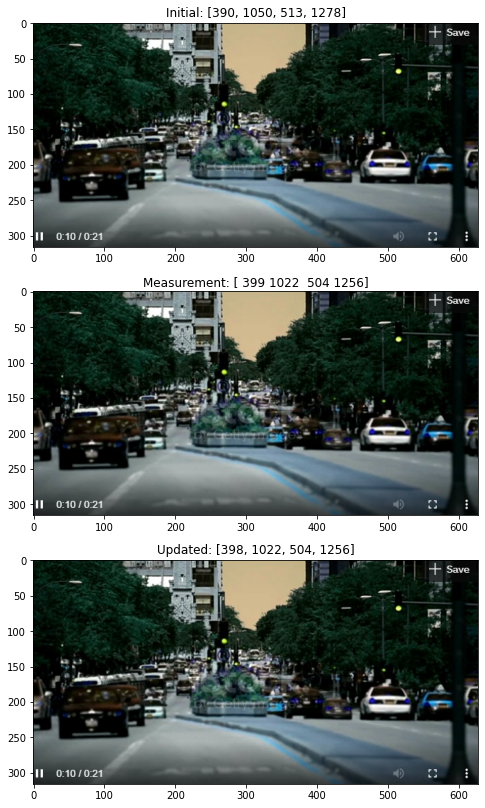

In [15]:

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

images = load_images_from_folder('/content/Datasets/image_datasets/training_new_model2')

if(len(images)>0):
    img=images[1]
    plt.figure(figsize=(10, 14))
    Helpers.draw_box_label(img, x_init_box, box_color=(0, 255, 0))
    ax = plt.subplot(3, 1, 1)
    plt.imshow(img)
    plt.title('Initial: '+str(x_init_box))

    Helpers.draw_box_label(img, z, box_color=(255, 0, 0))
    ax = plt.subplot(3, 1, 2)
    plt.imshow(img)
    plt.title('Measurement: '+str(z))

    Helpers.draw_box_label(img, x_updated_box)
    ax = plt.subplot(3, 1, 3)
    plt.imshow(img)
    plt.title('Updated: '+str(x_updated_box))
    plt.show()  
else:
  print('no testing images exist at',dataset_path)
  

In [16]:
pip install scikit-learn==0.22.2

     |████████████████████████████████| 7.1 MB 8.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22.2 which is incompatible.


# Combine Object detection and tracking 

In [21]:
from sklearn.utils.linear_assignment_ import linear_assignment
from Helpers import *
import Helpers

# Global variables to be used by funcitons of VideoFileClop
frame_count = 0 # frame counter

max_age = 4  # no.of consecutive unmatched detection before 
             # a track is deleted

min_hits =1  # no. of consecutive matches needed to establish a track

tracker_list =[] # list for trackers
# list for track ID
track_id_list= deque(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'])

debug = True

def assign_detections_to_trackers(trackers, detections, iou_thrd = 0.3):
    '''
    From current list of trackers and new detections, output matched detections,
    unmatchted trackers, unmatched detections.
    '''    
    
    IOU_mat= np.zeros((len(trackers),len(detections)),dtype=np.float32)
    for t,trk in enumerate(trackers):
        #trk = convert_to_cv2bbox(trk) 
        for d,det in enumerate(detections):
         #   det = convert_to_cv2bbox(det)
            IOU_mat[t,d] = box_iou2(trk,det) 
    
    # Produces matches       
    # Solve the maximizing the sum of IOU assignment problem using the
    # Hungarian algorithm (also known as Munkres algorithm)
    
    matched_idx = linear_assignment(-IOU_mat)        
    unmatched_trackers, unmatched_detections = [], []
    for t,trk in enumerate(trackers):
        if(t not in matched_idx[:,0]):
            unmatched_trackers.append(t)
    
    for d, det in enumerate(detections):
        if(d not in matched_idx[:,1]):
            unmatched_detections.append(d)

    matches = []
   
    # For creating trackers we consider any detection with an 
    # overlap less than iou_thrd to signifiy the existence of 
    # an untracked object
    
    for m in matched_idx:
        if(IOU_mat[m[0],m[1]]<iou_thrd):
            unmatched_trackers.append(m[0])
            unmatched_detections.append(m[1])
        else:
            matches.append(m.reshape(1,2))
    
    if(len(matches)==0):
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)
    
    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)       
    


def pipeline(img):
    '''
    Pipeline function for detection and tracking
    '''
    global frame_count
    global tracker_list
    global max_age
    global min_hits
    global track_id_list
    global debug

    frame_count+=1
    
    img_dim = (img.shape[1], img.shape[0])
    z_box = get_localization(img) # measurement
    if debug:
       print('Frame:', frame_count)
       
    x_box =[]
    if debug: 
        for i in range(len(z_box)):
           img1= Helpers.draw_box_label(img, z_box[i], box_color=(255, 0, 0))
           plt.imshow(img1)
        plt.show()
    
    if len(tracker_list) > 0:
        for trk in tracker_list:
            x_box.append(trk.box)
    
    
    matched, unmatched_dets, unmatched_trks \
    = assign_detections_to_trackers(x_box, z_box, iou_thrd = 0.3)  
    if debug:
         print('Detection: ', z_box)
         print('x_box: ', x_box)
         print('matched:', matched)
         print('unmatched_det:', unmatched_dets)
         print('unmatched_trks:', unmatched_trks)
    
         
    # Deal with matched detections     
    if matched.size >0:
        for trk_idx, det_idx in matched:
            z = z_box[det_idx]
            z = np.expand_dims(z, axis=0).T
            tmp_trk= tracker_list[trk_idx]
            tmp_trk.kalman_filter(z)
            xx = tmp_trk.x_state.T[0].tolist()
            xx =[xx[0], xx[2], xx[4], xx[6]]
            x_box[trk_idx] = xx
            tmp_trk.box =xx
            tmp_trk.hits += 1
            tmp_trk.no_losses = 0
    
    # Deal with unmatched detections      
    if len(unmatched_dets)>0:
        for idx in unmatched_dets:
            z = z_box[idx]
            z = np.expand_dims(z, axis=0).T
            tmp_trk = Tracker() # Create a new tracker
            x = np.array([[z[0], 0, z[1], 0, z[2], 0, z[3], 0]]).T
            tmp_trk.x_state = x
            tmp_trk.predict_only()
            xx = tmp_trk.x_state
            xx = xx.T[0].tolist()
            xx =[xx[0], xx[2], xx[4], xx[6]]
            tmp_trk.box = xx
            if(len(track_id_list)): 
              tmp_trk.id = track_id_list.popleft() # assign an ID for the tracker
              tracker_list.append(tmp_trk)
            x_box.append(xx)
    
    # Deal with unmatched tracks       
    if len(unmatched_trks)>0:
        for trk_idx in unmatched_trks:
            tmp_trk = tracker_list[trk_idx]
            tmp_trk.no_losses += 1
            tmp_trk.predict_only()
            xx = tmp_trk.x_state
            xx = xx.T[0].tolist()
            xx =[xx[0], xx[2], xx[4], xx[6]]
            tmp_trk.box =xx
            x_box[trk_idx] = xx
                   
       
    # The list of tracks to be annotated  
    good_tracker_list =[]
    for trk in tracker_list:
        if ((trk.hits >= min_hits) and (trk.no_losses <=max_age)):
             good_tracker_list.append(trk)
             x_cv2 = trk.box
             if debug:
                 print('updated box: ', x_cv2)
                 print()
             img= Helpers.draw_box_label(img, x_cv2) # Draw the bounding boxes on the 
                                             # images
    # Book keeping
    deleted_tracks = filter(lambda x: x.no_losses >max_age, tracker_list)  
    
    for trk in deleted_tracks:
            track_id_list.append(trk.id)
    
    tracker_list = [x for x in tracker_list if x.no_losses<=max_age]
    
    if debug:
       print('Ending tracker_list: ',len(tracker_list))
       print('Ending good tracker_list: ',len(good_tracker_list))
    
       
    return img
 


# Detection and tracking on extracted images

[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3995334888370543 class :  1
[166  79 230 155] , confidence:  0.56296736 ratio: 0.8419944744112616 class :  1
[179 531 226 593] , confidence:  0.5612419 ratio: 0.7579422673762297 class :  1
[147 146 204 182] , confidence:  0.51319224 ratio: 1.5828936406553735 class :  1
[162   2 279  99] , confidence:  0.51115364 ratio: 1.2060612308009484 class :  1
[156 329 220 383] , confidence:  0.4733462 ratio: 1.1849657470838735 class :  1
[185 383 224 441] , confidence:  0.39869392 ratio: 0.6722978796759179 class :  1
Frame: 16


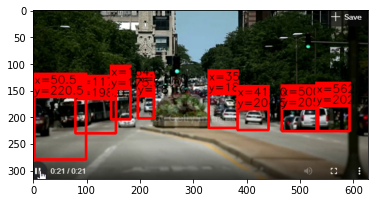

  FutureWarning)



Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

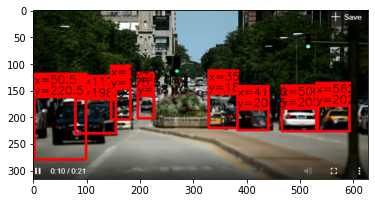

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

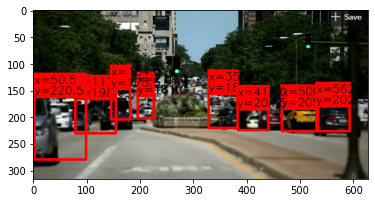

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

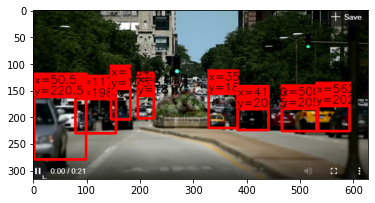

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

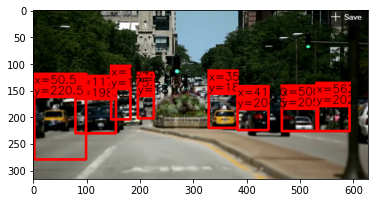

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

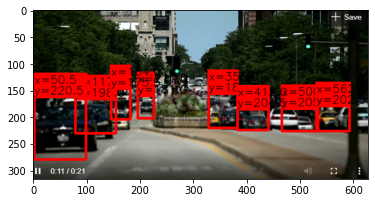

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

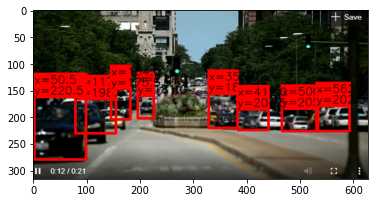

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

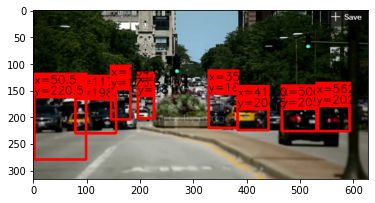

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

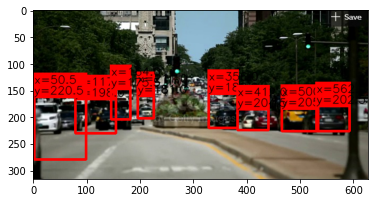

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

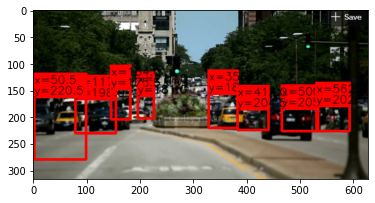

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

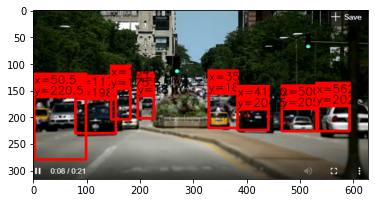

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

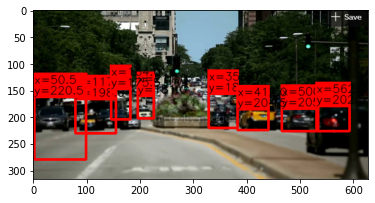

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

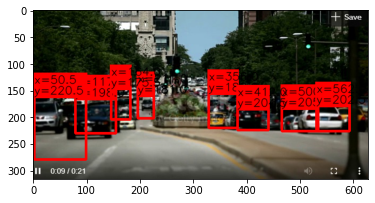

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

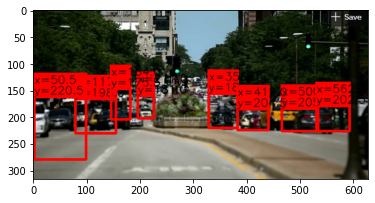

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
[184 466 226 534] , confidence:  0.6389962 ratio: 0.6175562417291575 class :  1
[160 196 202 226] , confidence:  0.59818625 ratio: 1.3

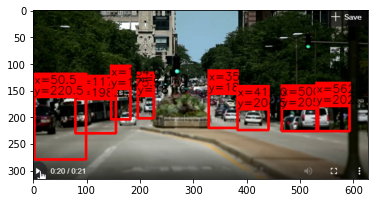

Detection:  [array([184, 466, 226, 534]), array([160, 196, 202, 226]), array([166,  79, 230, 155]), array([179, 531, 226, 593]), array([147, 146, 204, 182]), array([162,   2, 279,  99]), array([156, 329, 220, 383]), array([185, 383, 224, 441])]
x_box:  [[184, 466, 226, 534], [160, 196, 202, 226], [166, 79, 230, 155], [179, 531, 226, 593], [147, 146, 204, 182], [162, 2, 279, 99], [156, 329, 220, 383], [185, 383, 224, 441]]
matched: [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]]
unmatched_det: []
unmatched_trks: []
updated box:  [184, 466, 226, 534]

updated box:  [160, 196, 202, 226]

updated box:  [166, 79, 230, 155]

updated box:  [179, 531, 226, 593]

updated box:  [147, 146, 204, 182]

updated box:  [162, 2, 279, 99]

updated box:  [156, 329, 220, 383]

updated box:  [185, 383, 224, 441]

Ending tracker_list:  8
Ending good tracker_list:  8
 ====================         done processing         ====================


In [23]:
if debug: # test on a sequence of images
    seq = []
    for i in range(len(images)):
        image = images[i]
        image_box = pipeline(image)
        seq.append(image_box)
    print(' ====================         done processing         ====================')
    cnt =0
    for im in seq:
        # cv2.imshow("test",im)
        # cv2.waitKey(200)
        cnt+=1
        path = '/content/Datasets/image_datasets/final_write'
        cv2.imwrite(os.path.join(path , str(cnt)+'_img.jpg'), img)

else: # test on a video file.
    start=time.time()
    output = 'detection_and_tracking_output_video.mp4'
    clip1 = VideoFileClip('/content/sample_vid2.mp4')
    clip = clip1.fl_image(pipeline)
    clip.write_videofile(output, audio=False)
    end  = time.time()
    print(round(end-start, 2), 'Seconds to finish')